# Description of the Sign-Language MNIST Problem (American Sign Language)
American Sign Language (ASL) is a complete, natural language that has the same linguistic properties as spoken languages, with grammar that differs from English. ASL is expressed by movements of the hands and face. It is the primary language of many North Americans who are deaf and hard of hearing, and is used by many hearing people as well.
The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity.
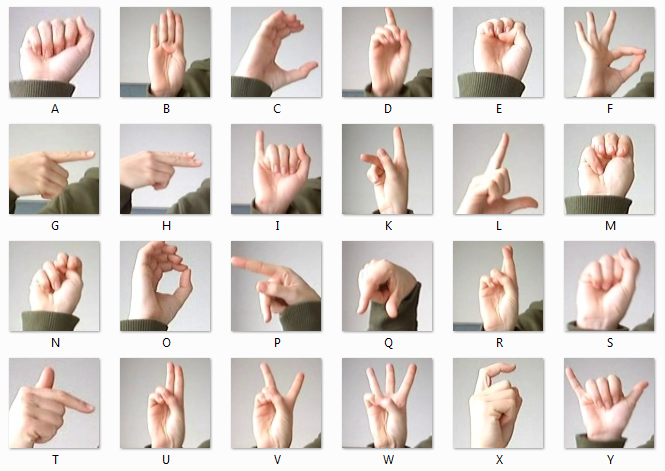

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

# Loading the ASL dataset

In [ ]:
train_df = pd.read_csv("../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

In [ ]:
test = pd.read_csv("../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")
y = test['label']

In [ ]:
train_df.head()

# Data Visualization and Preprocessing

In [ ]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])

**The dataset seems balanced as for each training label , enough training examples exist**

In [ ]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [ ]:
x_train = train_df.values
x_test = test_df.values

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [ ]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

**Preview of first 10 images**

In [ ]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    

# Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify.

Once our model is ready, we fit the training dataset .

# CONVOLUTIONAL NEURAL NETWORKS TO THE RESCUE
**A Convolutional Neural Network is a special type of an Artificial Intelligence implementation which uses a special mathematical matrix manipulation called the convolution operation to process data from the images.**

* **A convolution does this by multiplying two matrices and yielding a third, smaller matrix.**
* **The Network takes an input image, and uses a filter (or kernel) to create a feature map describing the image.**
* **In the convolution operation, we take a filter (usually 2x2 or 3x3 matrix ) and slide it over the image matrix. The coresponding numbers in both matrices are multiplied and and added to yield a single number describing that input space. This process is repeated all over the image.This working can be seen in the following figure**
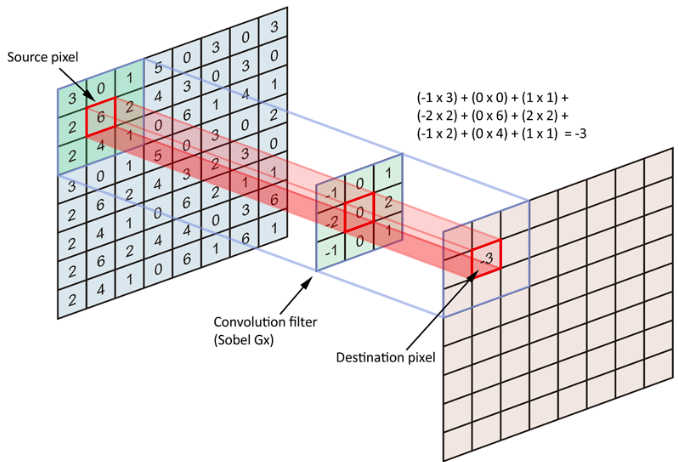

# Training The Model

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

# Analysis after Model Training

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]        

In [ ]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

In [ ]:
cm = confusion_matrix(y,predictions)

In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
correct = np.nonzero(predictions == y)[0]

**Some of the Correctly Predicted Classes**

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1